#####  importing Important libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from datetime import datetime, timedelta,date ,time

#### importing the data (tweets 5 min and ticker data 5 min frequency)

In [3]:
tweet_df = pd.read_csv('mean_sentiment_df_5min_from_January.csv')
tick_df = pd.read_csv('TICKERS_FTSE100_5MIN.csv')
tweet_df = tweet_df.drop(columns=['Unnamed: 0'])
tick_df = tick_df.drop(columns=['Unnamed: 0'])
tick_df['date'] = pd.to_datetime(tick_df['date'],utc=False)

In [4]:
tick_df.head()

,date,price,TICKER
0,2022-01-03 09:00:00,18.20,AAL
1,2022-01-03 09:05:00,18.20,AAL
2,2022-01-03 09:10:00,18.20,AAL
3,2022-01-03 09:15:00,18.16,AAL
4,2022-01-03 09:20:00,18.16,AAL


In [5]:
# ticker_df = pd.DataFrame()
# for index,day_df in tick_df.groupby(tick_df.date.dt.date):
#     temp_df = day_df.loc[(day_df['date'].dt.time >= time(9,00,00)) & (day_df['date'].dt.time <= time(15,00,00))]
#     ticker_df = pd.concat([ticker_df,temp_df])

In [6]:
ticker_list = list(tick_df['TICKER'].value_counts().index[:10].values)
top_10_df = tick_df.loc[tick_df['TICKER'].isin(ticker_list)]

In [7]:
top_10_df.groupby('TICKER').describe()

price                                                        \
          count        mean        std       min        25%       50%   
TICKER                                                                  
AAL     18531.0   17.329520   1.494401   12.5573   16.39000   17.2300   
AZN     12146.0   62.361075   4.085179   54.9200   58.39000   61.6775   
BA      15621.0  181.858730  29.783579  117.2600  170.03500  188.2500   
BP      15427.0   30.530633   1.483806   26.6600   29.35255   30.6100   
BTI     12104.0   42.579205   1.880645   37.3700   41.55000   42.7100   
CUK     13643.0   17.314614   2.579407   10.7300   16.06000   17.6700   
GSK     11416.0   43.927024   1.591200   38.7400   43.15000   44.0482   
HL      11367.0    5.726812   0.862404    4.0750    5.02000    5.4250   
MRO     14267.0   23.542208   3.359649   16.4100   21.15000   23.7600   
RIO     12972.0   74.774280   4.796374   62.3100   71.33000   74.8300   

                            
              75%      max  
TICKER                      
AAL      18.57000   21.750  
AZN      66.06375   71.660  
BA      205.60000  229.200  
BP       31.69000   34.135  
BTI      43.57000   47.230  
CUK      19.20000   22.080  
GSK      45.04500   47.050  
HL        6.63500    7.605  
MRO      25.75500   33.050  
RIO      78.30125   85.500

In [8]:
df=top_10_df.pivot_table(columns='TICKER',index='date' ,values ='price',fill_value=np.nan)
df =df.dropna(axis=0)

##### visualising the time series

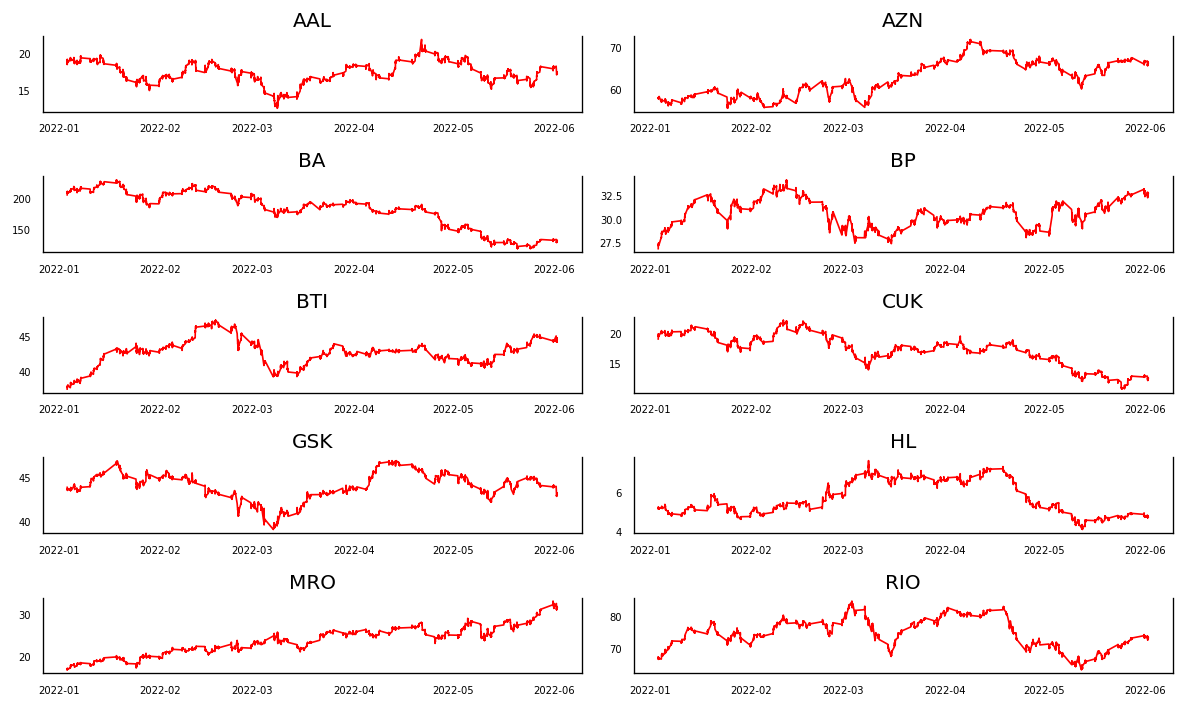

In [49]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    #ax.set_ylim(bottom=0 ,top = 100)


plt.tight_layout();

#### Testing Causation using Granger’s Causality Test
* The basis behind Vector AutoRegression is that each of the time series in the system influences each other.
* Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

In [9]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_df = grangers_causation_matrix(df, variables = df.columns) 
granger_df

,AAL_x,AZN_x,BA_x,BP_x,BTI_x,CUK_x,GSK_x,HL_x,MRO_x,RIO_x
AAL_y,1.0000,0.0477,0.0000,0.0011,0.4570,0.0415,0.0363,0.0000,0.0000,0.0001
AZN_y,0.0147,1.0000,0.0271,0.0520,0.2256,0.0426,0.0368,0.2500,0.2369,0.0250
BA_y,0.0000,0.1478,1.0000,0.0239,0.0484,0.0000,0.3045,0.0514,0.0024,0.1141
BP_y,0.7371,0.3035,0.3428,1.0000,0.1344,0.5044,0.0254,0.0000,0.0000,0.0164
BTI_y,0.0651,0.0270,0.1772,0.0000,1.0000,0.1839,0.0056,0.0004,0.0434,0.0069
CUK_y,0.0001,0.0029,0.0000,0.0081,0.1076,1.0000,0.0171,0.0001,0.0000,0.0041
GSK_y,0.0008,0.0000,0.0191,0.0000,0.0000,0.0007,1.0000,0.2213,0.0895,0.0000
HL_y,0.0015,0.0039,0.0390,0.0000,0.0526,0.0012,0.0034,1.0000,0.0000,0.0000
MRO_y,0.4785,0.0072,0.0130,0.0000,0.0041,0.0252,0.1197,0.0327,1.0000,0.0001
RIO_y,0.8242,0.3548,0.0655,0.0029,0.4307,0.1068,0.4434,0.6241,0.0158,1.0000


* Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.
* In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, we can safely reject the null hypothesis and hence X series causes Y series

In [10]:
granger_df.style.apply(lambda x: ["background: red" if v < 0.01 else "" for v in x], axis = 1)

,AAL_x,AZN_x,BA_x,BP_x,BTI_x,CUK_x,GSK_x,HL_x,MRO_x,RIO_x
AAL_y,1.000000,0.047700,0.000000,0.001100,0.457000,0.041500,0.036300,0.000000,0.000000,0.000100
AZN_y,0.014700,1.000000,0.027100,0.052000,0.225600,0.042600,0.036800,0.250000,0.236900,0.025000
BA_y,0.000000,0.147800,1.000000,0.023900,0.048400,0.000000,0.304500,0.051400,0.002400,0.114100
BP_y,0.737100,0.303500,0.342800,1.000000,0.134400,0.504400,0.025400,0.000000,0.000000,0.016400
BTI_y,0.065100,0.027000,0.177200,0.000000,1.000000,0.183900,0.005600,0.000400,0.043400,0.006900
CUK_y,0.000100,0.002900,0.000000,0.008100,0.107600,1.000000,0.017100,0.000100,0.000000,0.004100
GSK_y,0.000800,0.000000,0.019100,0.000000,0.000000,0.000700,1.000000,0.221300,0.089500,0.000000
HL_y,0.001500,0.003900,0.039000,0.000000,0.052600,0.001200,0.003400,1.000000,0.000000,0.000000
MRO_y,0.478500,0.007200,0.013000,0.000000,0.004100,0.025200,0.119700,0.032700,1.000000,0.000100
RIO_y,0.824200,0.354800,0.065500,0.002900,0.430700,0.106800,0.443400,0.624100,0.015800,1.000000


#####  Cointegration Test
* Cointegration test helps to establish the presence of a statistically significant connection between two or more time series

In [23]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
AAL    ::  216.93    > 219.4051  =>   False
AZN    ::  171.37    > 179.5199  =>   False
BA     ::  135.9     > 143.6691  =>   False
BP     ::  102.41    > 111.7797  =>   False
BTI    ::  74.36     > 83.9383   =>   False
CUK    ::  51.84     > 60.0627   =>   False
GSK    ::  32.81     > 40.1749   =>   False
HL     ::  15.8      > 24.2761   =>   False
MRO    ::  6.69      > 12.3212   =>   False
RIO    ::  0.46      > 4.1296    =>   False


In [13]:
nobs = df.loc[df.index >= '2022-05-01 00:00:00'].shape[0]
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(6786, 10)
(1786, 10)


##### Check for Stationarity and Make the Time Series Stationary
* Augmented Dickey-Fuller Test (ADF Test)

In [26]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AAL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7595
 No. Lags Chosen       = 3
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.4007. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "AZN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.0593
 No. Lags Chosen       = 3
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.731. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "BA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

In [14]:
# 1st difference
df_differenced = np.log(df_train).diff().dropna()
df_test_diff = np.log(df_test).diff().dropna()

In [29]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AAL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -48.8987
 No. Lags Chosen       = 2
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AZN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.0295
 No. Lags Chosen       = 15
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

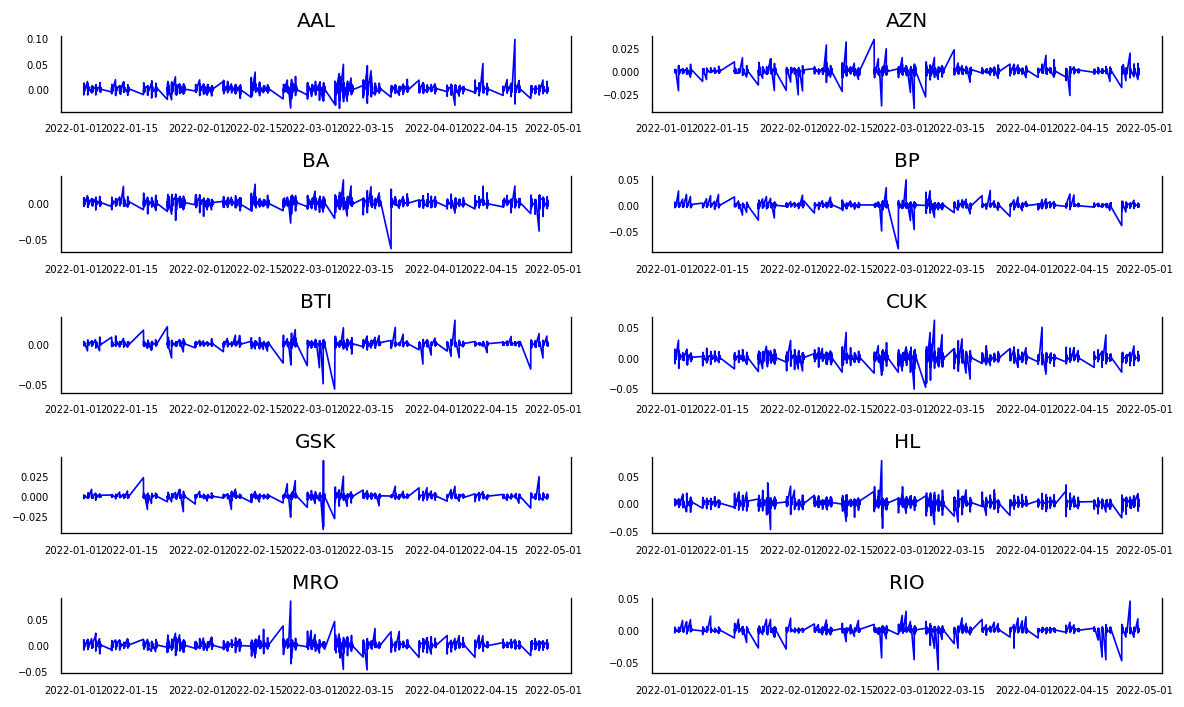

In [56]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_differenced[df_differenced.columns[i]]
    ax.plot(data, color='b', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

#####  To Select the Order (P) of VAR model
* To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

In [59]:
model = VAR(df_differenced)
AIC_list = []
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
    AIC_list.append(result.aic)

C:\Users\rkroc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Lag Order = 1
AIC :  -119.72679001188564
BIC :  -119.61616863223912
FPE :  1.0076640720249916e-52
HQIC:  -119.6886115439354 

Lag Order = 2
AIC :  -119.74157676211718
BIC :  -119.53036392122102
FPE :  9.928737841630363e-53
HQIC:  -119.66868088526512 

Lag Order = 3
AIC :  -119.7475226301926
BIC :  -119.43569301208105
FPE :  9.869882367408911e-53
HQIC:  -119.63990009211427 

Lag Order = 4
AIC :  -119.7456203496205
BIC :  -119.33314862808969
FPE :  9.888683798412125e-53
HQIC:  -119.60326189414091 

Lag Order = 5
AIC :  -119.73908642022711
BIC :  -119.2259472588294
FPE :  9.953520881515936e-53
HQIC:  -119.5619827873186 

Lag Order = 6
AIC :  -119.73079957944525
BIC :  -119.11696763148346
FPE :  1.0036367106962049e-52
HQIC:  -119.51894150522519 

Lag Order = 7
AIC :  -119.72605879426831
BIC :  -119.01150870279021
FPE :  1.0084088621070084e-52
HQIC:  -119.4794370109971 

Lag Order = 8
AIC :  -119.74461654194562
BIC :  -118.92932293973811
FPE :  9.898713216616873e-53
HQIC:  -119.463221778024

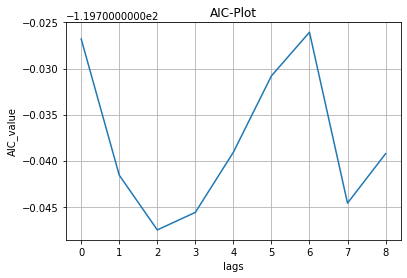

In [102]:
plt.plot(AIC_list)
plt.xlabel('lags')
plt.ylabel("AIC_value")
plt.title('AIC-Plot')
plt.grid()
plt.show()

* from the above plot the AIC drops at lag 2 and then again increase at lag 3 ,hence increases again we choose lag2

In [58]:
##### An alternate method to choose the order(p) of the VAR models is to use the model.select_order(maxlags) method.
maxlags = 12
find_lag = model.select_order(maxlags=12)
find_lag.summary()

,AIC,BIC,FPE,HQIC
0,-119.6,-119.6,1.114e-52,-119.6
1,-119.7,-119.6*,1.008e-52,-119.7*
2,-119.7,-119.5,9.929e-53,-119.7
3,-119.7*,-119.4,9.877e-53*,-119.6
4,-119.7,-119.3,9.896e-53,-119.6
5,-119.7,-119.2,9.980e-53,-119.6
6,-119.7,-119.1,1.007e-52,-119.5
7,-119.7,-119.0,1.011e-52,-119.5
8,-119.7,-118.9,9.917e-53,-119.5
9,-119.7,-118.8,9.958e-53,-119.4


In [97]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 03, Jul, 2022
Time:                     22:18:53
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -119.530
Nobs:                     6783.00    HQIC:                  -119.669
Log likelihood:           310067.    FPE:                9.92874e-53
AIC:                     -119.742    Det(Omega_mle):     9.62652e-53
--------------------------------------------------------------------
Results for equation AAL
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000011         0.000053            0.210           0.834
L1.AAL        -0.027646         0.020160           -1.371           0.170
L1.AZN        -0.034452         0.031300           -1.101           0.271
L1.BA          0

###### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
* Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).
* If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

In [105]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

AAL : 2.0
AZN : 2.0
BA : 2.0
BP : 2.0
BTI : 2.0
CUK : 2.0
GSK : 2.0
HL : 2.0
MRO : 2.0
RIO : 2.0


* A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.
* The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.
* The serial correlation seems quite alright. Let’s proceed with the forecast.

##### Forecast VAR model using statsmodels

In [112]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

2


array([[ 0.00074615, -0.00105414,  0.00040234, -0.00121834,  0.00107739,
         0.00126703,  0.00022097,  0.000962  ,  0.00040136, -0.000492  ],
       [ 0.00106496,  0.00045191, -0.00047019,  0.        , -0.00023932,
        -0.00031661,  0.00044179,  0.00192123,  0.        , -0.00154788]])

In [116]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
new_col = []
for col in df.columns:
    new_col.append(col+"_forecast")
    
df_forecast.columns = new_col
df_forecast = df_forecast.iloc[1:,:]

,AAL_forecast,AZN_forecast,BA_forecast,BP_forecast,BTI_forecast,CUK_forecast,GSK_forecast,HL_forecast,MRO_forecast,RIO_forecast
date,,,,,,,,,,
2022-05-02 13:30:00,-0.000355,-0.000042,-0.000052,-0.000040,0.000032,-0.000203,-0.000091,-4.142109e-04,-0.000018,0.000043
2022-05-02 13:35:00,-0.000149,0.000011,-0.000093,0.000056,0.000061,-0.000099,-0.000022,2.020046e-05,0.000040,0.000068
2022-05-02 13:40:00,0.000042,0.000028,-0.000035,0.000005,0.000011,-0.000013,0.000024,6.650258e-06,0.000073,-0.000001
2022-05-02 13:45:00,0.000015,0.000024,-0.000047,0.000007,0.000013,-0.000017,0.000005,7.452297e-06,0.000061,0.000008
2022-05-02 13:50:00,-0.000004,0.000019,-0.000049,0.000009,0.000017,-0.000032,0.000004,4.601275e-07,0.000057,0.000009
...,...,...,...,...,...,...,...,...,...,...
2022-06-01 19:40:00,0.000001,0.000020,-0.000048,0.000009,0.000016,-0.000029,0.000005,1.231604e-06,0.000058,0.000008
2022-06-01 19:45:00,0.000001,0.000020,-0.000048,0.000009,0.000016,-0.000029,0.000005,1.231604e-06,0.000058,0.000008
2022-06-01 19:50:00,0.000001,0.000020,-0.000048,0.000009,0.000016,-0.000029,0.000005,1.231604e-06,0.000058,0.000008


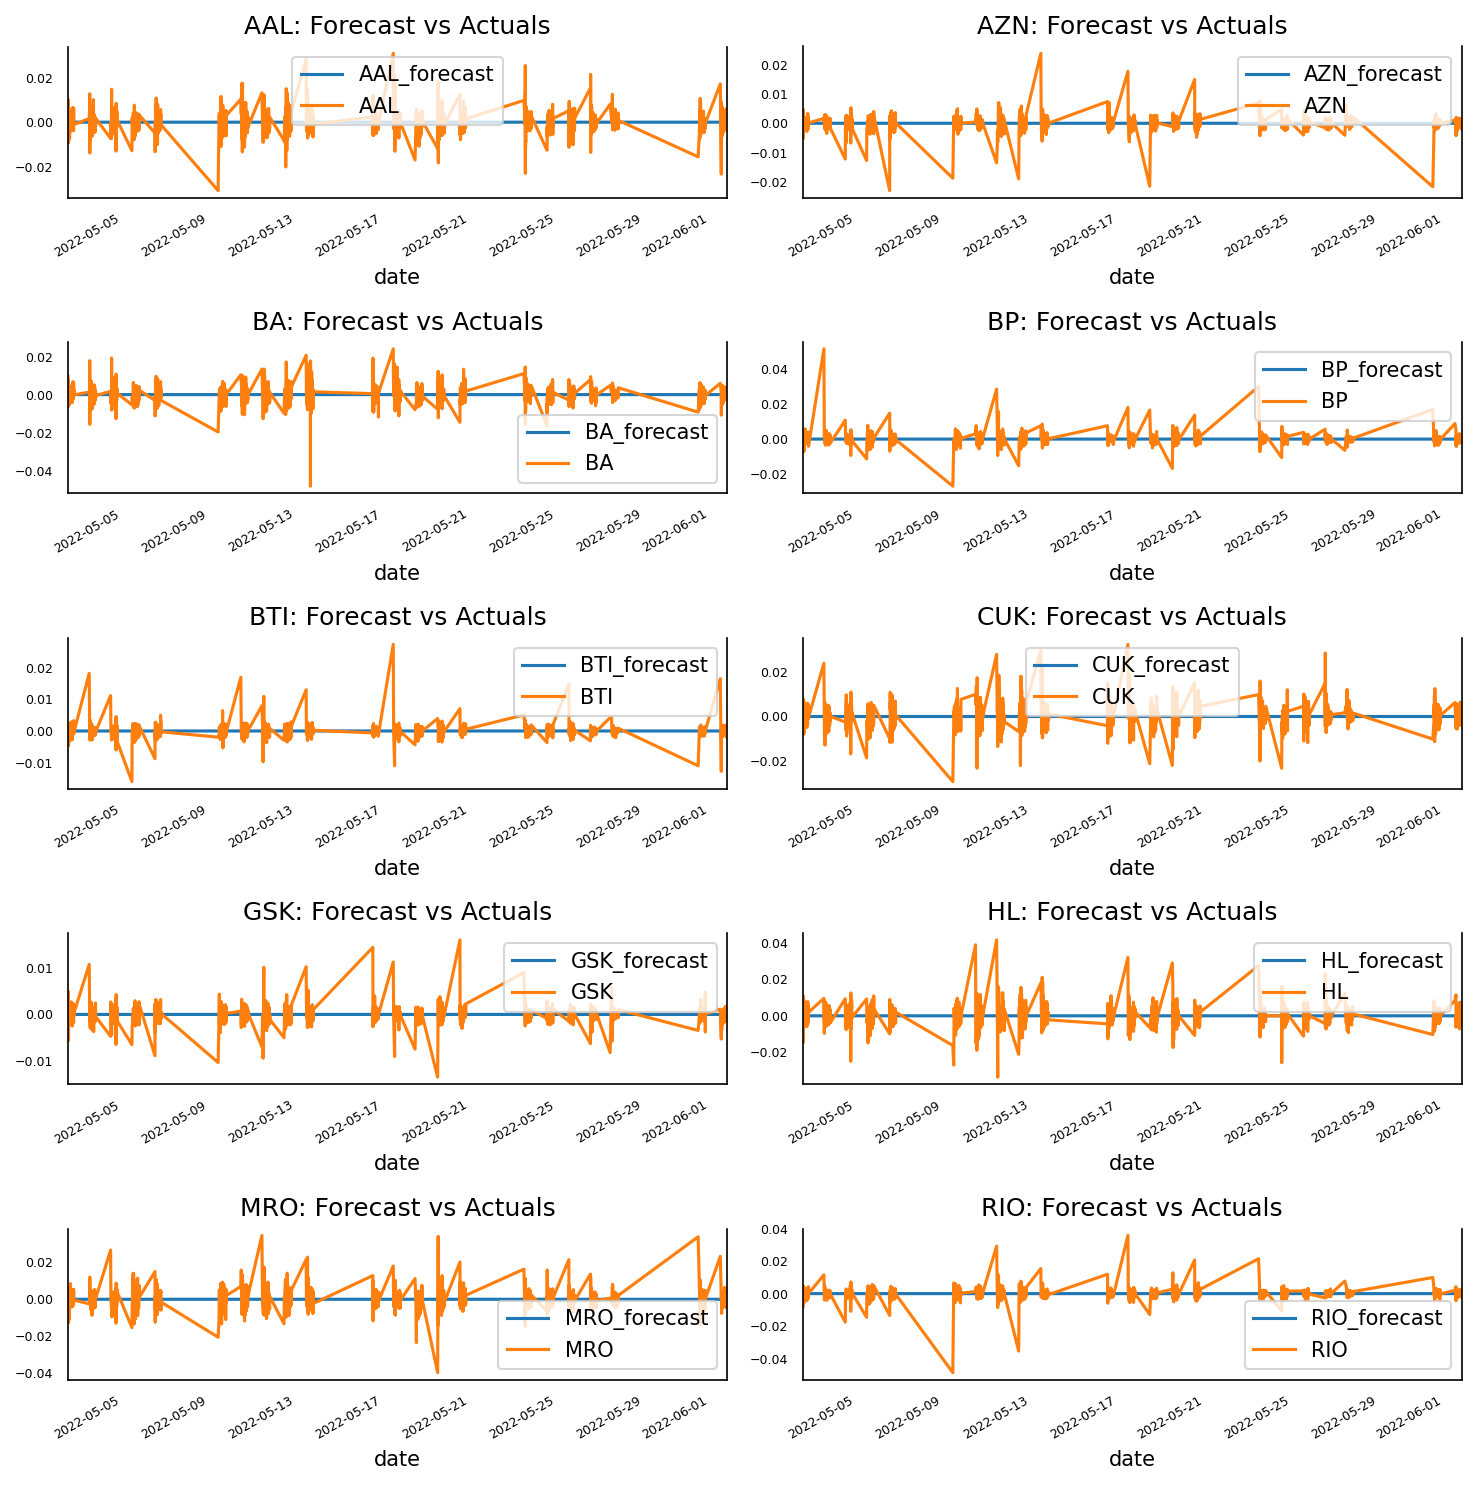

In [117]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test_diff[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [131]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    return({ 'rmse':rmse, 'corr':corr})


for col in df.columns:
    print('Forecast Accuracy of {}'.format(col))
    accuracy_prod = forecast_accuracy(df_forecast[col+"_forecast"].values, df_test_diff[col])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))

Forecast Accuracy of AAL
rmse :  0.0042
corr :  0.0518
Forecast Accuracy of AZN
rmse :  0.0021
corr :  -0.0002
Forecast Accuracy of BA
rmse :  0.0039
corr :  -0.0538
Forecast Accuracy of BP
rmse :  0.0029
corr :  0.0056
Forecast Accuracy of BTI
rmse :  0.0018
corr :  -0.0462
Forecast Accuracy of CUK
rmse :  0.0046
corr :  0.0093
Forecast Accuracy of GSK
rmse :  0.0015
corr :  0.034
Forecast Accuracy of HL
rmse :  0.0047
corr :  -0.0377
Forecast Accuracy of MRO
rmse :  0.0046
corr :  -0.0495
Forecast Accuracy of RIO
rmse :  0.0029
corr :  -0.0043


<ipython-input-131-5bbce2e41f95>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


##### Modelling a VAR for log return  after introducing the tweets as  an exogenous series

In [22]:
tweets = pd.read_csv('mean_sentiment_df_5min_from_January.csv')
tweets['Date'] = pd.to_datetime(tweets['Date'],utc=False)
tweets['Date'] = tweets['Date'].dt.tz_localize(None)
tweets = tweets[['Date','Vader-Compound']]
tweets.index = tweets['Date']
tweets.drop(columns='Date')
tweets = tweets.loc[df_differenced.index.values]
tweets.shape

(6785, 2)

In [27]:
split = int(0.60*df_differenced.shape[0])
diff_train = df_differenced.iloc[:split,:]
diff_test  = df_differenced.iloc[split:,:]
tweets_train = tweets.iloc[:split,:]
tweets_test  = tweets.iloc[split:,:]

In [38]:
exog = tweets_train['Vader-Compound']
mod = sm.tsa.VARMAX(diff_train.iloc[:,:], order=(2,0), trend='n', exog=exog.iloc[:])
res = mod.fit(maxiter=100, disp=False)
print(res.summary())

C:\Users\rkroc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                                    Statespace Model Results                                                   
Dep. Variable:     ['AAL', 'AZN', 'BA', 'BP', 'BTI', 'CUK', 'GSK', 'HL', 'MRO', 'RIO']   No. Observations:                 1000
Model:                                                                         VARX(2)   Log Likelihood               48438.583
Date:                                                                 Mon, 04 Jul 2022   AIC                         -96347.167
Time:                                                                         05:20:44   BIC                         -95046.612
Sample:                                                                              0   HQIC                        -95852.865
                                                                                - 1000                                         
Covariance Type:                                                                   opg                  

In [87]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({ 'rmse':rmse})

exog_fcast = np.array(tweets_test['Vader-Compound'].values[-1:])
print(f"The shape is {exog_fcast}")
array_forecasts = res.forecast(horizon=1, exog=exog_fcast)
print(array_forecasts.mean)
for col in diff_test.columns:
    print('Forecast Accuracy of {}'.format(col))
    accuracy_prod = forecast_accuracy(array_forecasts[col].values[0], diff_test.iloc[-1][col])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))

The shape is [0.36931667]
<bound method NDFrame._add_numeric_operations.<locals>.mean of            AAL       AZN        BA        BP       BTI       CUK       GSK  \
1000 -0.000638  0.000322 -0.000675 -0.000647  0.000612 -0.001388  0.000059   

            HL       MRO       RIO  
1000 -0.001435 -0.000309  0.000371  >
Forecast Accuracy of AAL
rmse :  0.0017
Forecast Accuracy of AZN
rmse :  0.0001
Forecast Accuracy of BA
rmse :  0.0002
Forecast Accuracy of BP
rmse :  0.0006
Forecast Accuracy of BTI
rmse :  0.0009
Forecast Accuracy of CUK
rmse :  0.0011
Forecast Accuracy of GSK
rmse :  0.0004
Forecast Accuracy of HL
rmse :  0.0034
Forecast Accuracy of MRO
rmse :  0.0003
Forecast Accuracy of RIO
rmse :  0.0019


C:\Users\rkroc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


##### Modelling for HIgher Momemnts:

In [88]:
hdf= pd.read_csv('TICKERS_FTSE100_60MIN_TWITTER_SENTIMENT.csv')
hdf = hdf[['date','TICKER','variance','sample-size','Vader-Compound']]
hdf

,date,TICKER,variance,sample-size,Vader-Compound
0,2022-01-03 09:00:00,AAL,1.816079e-06,9,0.285950
1,2022-01-03 10:00:00,AAL,9.038667e-07,10,0.056667
2,2022-01-03 11:00:00,AAL,5.182040e-07,9,0.162520
3,2022-01-03 12:00:00,AAL,7.990391e-07,12,0.471400
4,2022-01-03 13:00:00,AAL,1.054890e-06,12,0.211700
...,...,...,...,...,...
33333,2022-06-01 15:00:00,WPP,2.035268e-06,9,0.243867
33334,2022-06-01 16:00:00,WPP,7.964368e-07,9,0.326024
33335,2022-06-01 17:00:00,WPP,9.452507e-07,12,0.265945
33336,2022-06-01 18:00:00,WPP,1.676301e-06,11,0.354616


In [89]:
ticker_list = list(hdf['TICKER'].value_counts().index[:10].values)
hdf_10 = hdf.loc[hdf['TICKER'].isin(ticker_list)]

hdf_10[['date','variance','TICKER']].groupby('TICKER').describe()

variance                                                       \
          count      mean       std  min           25%           50%   
TICKER                                                                 
AAL      1646.0  0.000009  0.000019  0.0  1.168954e-06  3.669234e-06   
AZN      1188.0  0.000003  0.000007  0.0  6.319010e-07  1.311904e-06   
BA       1511.0  0.000006  0.000012  0.0  1.037719e-06  2.724916e-06   
BP       1552.0  0.000004  0.000007  0.0  9.252356e-07  2.042442e-06   
BTI      1189.0  0.000003  0.000007  0.0  4.627924e-07  9.598364e-07   
CUK      1291.0  0.000011  0.000017  0.0  2.838994e-06  5.642828e-06   
GSK      1135.0  0.000002  0.000012  0.0  3.709450e-07  8.265790e-07   
HL       1097.0  0.000025  0.000073  0.0  4.456523e-06  8.800054e-06   
MRO      1393.0  0.000012  0.000025  0.0  2.483371e-06  5.467963e-06   
RIO      1296.0  0.000004  0.000009  0.0  9.616229e-07  2.052665e-06   

                            
             75%       max  
TICKER                      
AAL     0.000009  0.000335  
AZN     0.000003  0.000158  
BA      0.000006  0.000258  
BP      0.000004  0.000144  
BTI     0.000002  0.000166  
CUK     0.000013  0.000191  
GSK     0.000002  0.000329  
HL      0.000022  0.001374  
MRO     0.000012  0.000627  
RIO     0.000005  0.000195

In [90]:
hdf_final = hdf_10.pivot_table(columns='TICKER',index='date' ,values ='variance',fill_value=np.nan)
hdf_final = hdf_final.dropna(axis=0)
hdf_final

TICKER,AAL,AZN,BA,BP,BTI,CUK,GSK,HL,MRO,RIO
date,,,,,,,,,,
2022-01-03 12:00:00,7.990391e-07,1.028548e-12,3.046573e-07,7.879527e-07,3.849519e-05,0.000002,2.040093e-14,0.000090,0.000092,2.384866e-07
2022-01-03 14:00:00,3.429058e-05,7.235252e-06,9.955463e-06,1.752637e-05,4.543710e-06,0.000038,1.666289e-05,0.000014,0.000041,1.143601e-05
2022-01-03 15:00:00,1.635100e-05,9.026086e-07,7.814551e-06,5.996566e-06,2.149076e-06,0.000027,1.202175e-06,0.000015,0.000007,2.605478e-06
2022-01-03 16:00:00,6.794992e-06,6.634720e-07,7.017529e-06,3.401699e-06,6.460318e-07,0.000005,4.597081e-07,0.000003,0.000006,1.819843e-06
2022-01-03 17:00:00,6.539822e-06,1.300108e-07,1.810457e-06,4.600233e-07,2.852297e-07,0.000007,1.491478e-07,0.000003,0.000003,6.004939e-07
...,...,...,...,...,...,...,...,...,...,...
2022-06-01 15:00:00,5.011060e-06,1.119107e-06,4.495974e-06,2.353576e-06,4.694402e-07,0.000004,6.329452e-07,0.000006,0.000004,1.508628e-06
2022-06-01 16:00:00,4.796374e-06,6.962081e-07,2.968448e-06,1.247414e-06,2.541631e-07,0.000007,8.439740e-07,0.000008,0.000004,1.332931e-06
2022-06-01 17:00:00,2.702567e-06,8.292822e-07,2.473600e-06,2.346011e-06,5.157340e-07,0.000005,1.672370e-07,0.000012,0.000010,1.247314e-06


In [91]:
tweets = hdf_10.pivot_table(columns='TICKER',index='date' ,values ='Vader-Compound',fill_value=np.nan)

In [92]:
merge_df=pd.merge(tweets,hdf_final, how='inner', left_index=True, right_index=True)
tweet_mat = merge_df.iloc[:,:10]
tweet_mat.columns = tweets.columns
tweet_mat

TICKER,AAL,AZN,BA,BP,BTI,CUK,GSK,HL,MRO,RIO
date,,,,,,,,,,
2022-01-03 12:00:00,0.471400,0.471400,0.471400,0.471400,0.471400,0.471400,0.471400,0.471400,0.471400,0.471400
2022-01-03 14:00:00,0.101623,0.101623,0.101623,0.101623,0.101623,0.101623,0.101623,0.101623,0.101623,0.101623
2022-01-03 15:00:00,0.194259,0.194259,0.194259,0.194259,0.194259,0.194259,0.194259,0.194259,0.194259,0.194259
2022-01-03 16:00:00,0.250085,0.250085,0.250085,0.250085,0.250085,0.250085,0.250085,0.250085,0.250085,0.250085
2022-01-03 17:00:00,0.351496,0.351496,0.351496,0.351496,0.351496,0.351496,0.351496,0.351496,0.351496,0.351496
...,...,...,...,...,...,...,...,...,...,...
2022-06-01 15:00:00,0.243867,0.243867,0.243867,0.243867,0.243867,0.243867,0.243867,0.243867,0.243867,0.243867
2022-06-01 16:00:00,0.326024,0.326024,0.326024,0.326024,0.326024,0.326024,0.326024,0.326024,0.326024,0.326024
2022-06-01 17:00:00,0.265945,0.265945,0.265945,0.265945,0.265945,0.265945,0.265945,0.265945,0.265945,0.265945


In [93]:
granger_hdf = grangers_causation_matrix(hdf_final,variables= hdf_final.columns)
granger_hdf

,AAL_x,AZN_x,BA_x,BP_x,BTI_x,CUK_x,GSK_x,HL_x,MRO_x,RIO_x
AAL_y,1.0000,0.0001,0.1326,0.0017,0.0015,0.0000,0.0000,0.0000,0.0006,0.0000
AZN_y,0.0000,1.0000,0.0070,0.0000,0.0001,0.0000,0.0000,0.0012,0.0000,0.0208
BA_y,0.0638,0.0408,1.0000,0.0017,0.0375,0.0016,0.8830,0.0000,0.0043,0.0000
BP_y,0.0026,0.0000,0.1136,1.0000,0.0000,0.0015,0.0000,0.0000,0.0090,0.0000
BTI_y,0.0001,0.0096,0.0560,0.0000,1.0000,0.0000,0.0017,0.0000,0.0094,0.0000
CUK_y,0.0000,0.0000,0.0316,0.0000,0.0002,1.0000,0.0000,0.0000,0.0007,0.0000
GSK_y,0.6486,0.1025,0.7503,0.0016,0.0230,0.0323,1.0000,0.4925,0.6774,0.3487
HL_y,0.0000,0.0002,0.0000,0.0000,0.5542,0.0000,0.6132,1.0000,0.0000,0.0013
MRO_y,0.0001,0.0017,0.0475,0.0304,0.0204,0.0002,0.0121,0.0000,1.0000,0.0002
RIO_y,0.0000,0.0244,0.1320,0.0000,0.0011,0.0000,0.3986,0.1339,0.0000,1.0000


* Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.
* In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, we can safely reject the null hypothesis and hence X series causes Y series

* Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.
* In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, we can safely reject the null hypothesis and hence X series causes Y series

In [35]:
granger_hdf.style.apply(lambda x: ["background: blue" if v < 0.01 else "" for v in x], axis = 1)

,AAL_x,AZN_x,BA_x,BP_x,BTI_x,CUK_x,GSK_x,HL_x,MRO_x,RIO_x
AAL_y,1.000000,0.000100,0.132600,0.001700,0.001500,0.000000,0.000000,0.000000,0.000600,0.000000
AZN_y,0.000000,1.000000,0.007000,0.000000,0.000100,0.000000,0.000000,0.001200,0.000000,0.020800
BA_y,0.063800,0.040800,1.000000,0.001700,0.037500,0.001600,0.883000,0.000000,0.004300,0.000000
BP_y,0.002600,0.000000,0.113600,1.000000,0.000000,0.001500,0.000000,0.000000,0.009000,0.000000
BTI_y,0.000100,0.009600,0.056000,0.000000,1.000000,0.000000,0.001700,0.000000,0.009400,0.000000
CUK_y,0.000000,0.000000,0.031600,0.000000,0.000200,1.000000,0.000000,0.000000,0.000700,0.000000
GSK_y,0.648600,0.102500,0.750300,0.001600,0.023000,0.032300,1.000000,0.492500,0.677400,0.348700
HL_y,0.000000,0.000200,0.000000,0.000000,0.554200,0.000000,0.613200,1.000000,0.000000,0.001300
MRO_y,0.000100,0.001700,0.047500,0.030400,0.020400,0.000200,0.012100,0.000000,1.000000,0.000200
RIO_y,0.000000,0.024400,0.132000,0.000000,0.001100,0.000000,0.398600,0.133900,0.000000,1.000000


In [173]:
### for variance series is staionary in itself ,no need of differencing
for name, column in hdf_final.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AAL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1666
 No. Lags Chosen       = 8
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AZN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.2286
 No. Lags Chosen       = 9
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

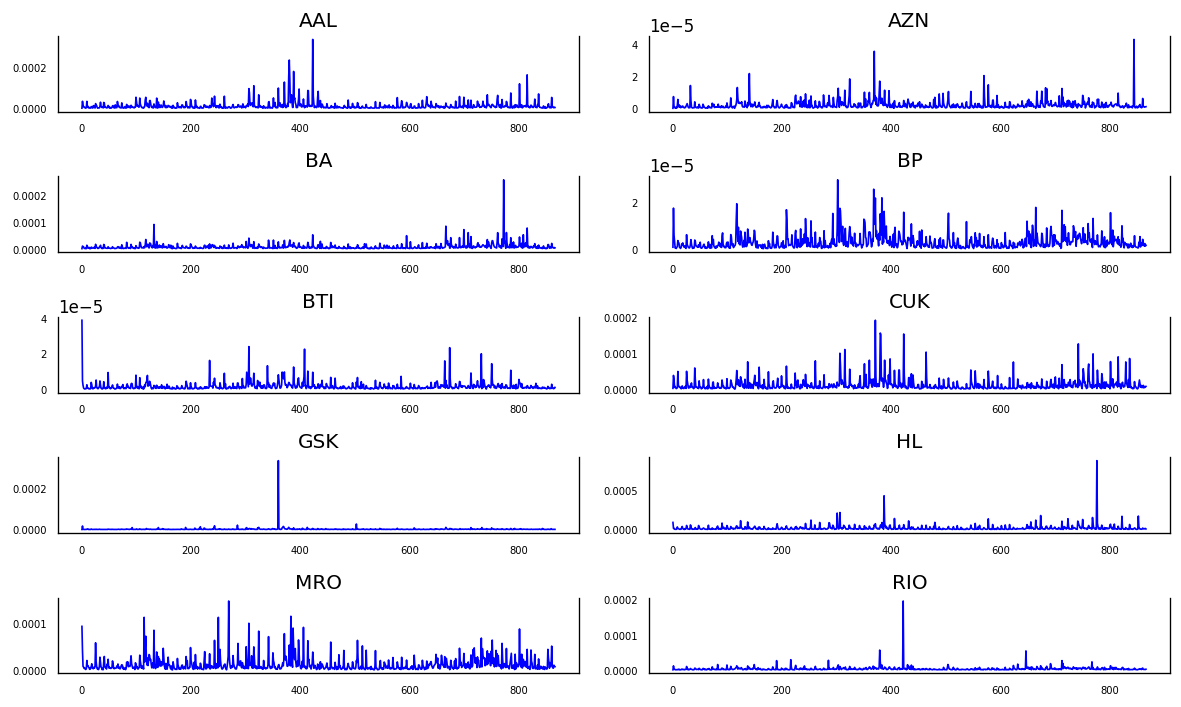

In [177]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = hdf_final[hdf_final.columns[i]].values
    ax.plot(data, color='b', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

C:\Users\rkroc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Text(0.5, 1.0, 'Lag Plot for Variance')

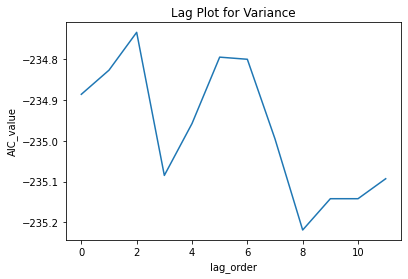

In [183]:
model = VAR(hdf_final)
AIC_list = []
for i in [1,2,3,4,5,6,7,8,9,10,10,12]:
    result = model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')
    AIC_list.append(result.aic)
plt.plot(AIC_list)
plt.xlabel("lag_order")
plt.ylabel("AIC_value")
plt.title("Lag Plot for Variance")

In [112]:
model = VAR(hdf_final.iloc[:,:5])
model_fitted = model.fit(8)
model_fitted.summary()

C:\Users\rkroc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Jul, 2022
Time:                     06:11:31
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -120.675
Nobs:                     860.000    HQIC:                  -121.375
Log likelihood:           46481.3    FPE:                1.25702e-53
AIC:                     -121.809    Det(Omega_mle):     9.95890e-54
--------------------------------------------------------------------
Results for equation AAL
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000003         0.000002            1.915           0.055
L1.AAL         0.255496         0.040144            6.365           0.000
L1.AZN         0.332756         0.268802            1.238           0.216
L1.BA         -0

In [116]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = hdf_final.values[-lag_order:,:5]
forecast_input.shape

8


(8, 5)

In [119]:
# Forecast
fc = model_fitted.forecast(y=forecast_input,steps = hdf_final.shape[0])
df_forecast = pd.DataFrame(fc, index=hdf_final.index[:], columns=hdf_final.columns[:5] + '_2d')
new_col = []
for col in hdf_final.columns[:5]:
    new_col.append(col+"_forecast")
    
df_forecast.columns = new_col
#df_forecast = df_forecast.iloc[1:,:]

In [120]:
df_forecast

,AAL_forecast,AZN_forecast,BA_forecast,BP_forecast,BTI_forecast
date,,,,,
2022-01-03 12:00:00,0.000006,0.000002,0.000006,0.000002,0.000002
2022-01-03 14:00:00,0.000020,0.000003,0.000009,0.000004,0.000002
2022-01-03 15:00:00,0.000016,0.000002,0.000008,0.000003,0.000002
2022-01-03 16:00:00,0.000012,0.000002,0.000007,0.000003,0.000001
2022-01-03 17:00:00,0.000009,0.000002,0.000006,0.000002,0.000001
...,...,...,...,...,...
2022-06-01 15:00:00,0.000013,0.000002,0.000008,0.000003,0.000002
2022-06-01 16:00:00,0.000013,0.000002,0.000008,0.000003,0.000002
2022-06-01 17:00:00,0.000013,0.000002,0.000008,0.000003,0.000002


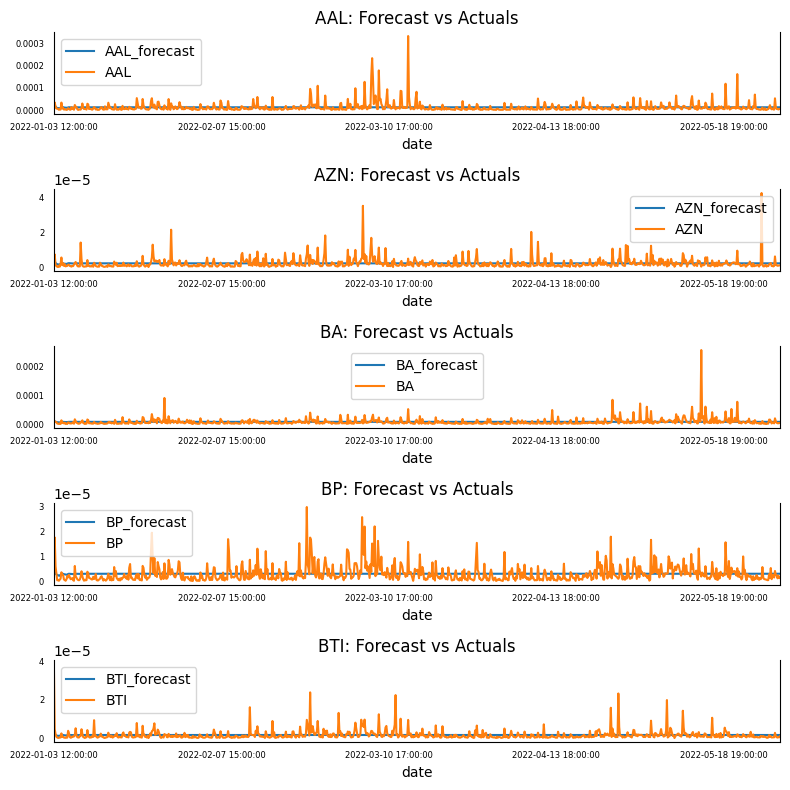

In [128]:
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=100, figsize=(8,8))
for i, (col,ax) in enumerate(zip(hdf_final.columns, axes.flatten())):
    df_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    hdf_final[col][:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [121]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    return({ 'rmse':rmse, 'corr':corr})


for col in df.columns:
    print('Forecast Accuracy of {}'.format(col))
    accuracy_prod = forecast_accuracy(df_forecast[col+"_forecast"].values, hdf_final[col])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))

Forecast Accuracy of AAL
rmse :  0.0
corr :  0.0596
Forecast Accuracy of AZN
rmse :  0.0
corr :  0.0804
Forecast Accuracy of BA
rmse :  0.0
corr :  0.0549
Forecast Accuracy of BP
rmse :  0.0
corr :  0.1345
Forecast Accuracy of BTI
rmse :  0.0
corr :  0.1043
Forecast Accuracy of CUK


<ipython-input-121-99fedfeb7e05>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


KeyError: 'CUK_forecast'

#### VAR modelling for higher moment (variance) with including tweets as exogenous variable

In [106]:
split = int(hdf_final.shape[0]*0.60)
hdf_train = hdf_final.iloc[:split,:]
hdf_test = hdf_final.iloc[split:,:]
tweet_train = tweet_mat.iloc[:split,:]
tweet_test = tweet_mat.iloc[split:,:]

In [110]:
mod = sm.tsa.VARMAX(hdf_train.iloc[:,:5], order=(8,0), trend='n',exog = tweet_train.iloc[:,:1])
res = mod.fit(maxiter=100, disp=False)
print(res.summary())

C:\Users\rkroc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                   Statespace Model Results                                  
Dep. Variable:     ['AAL', 'AZN', 'BA', 'BP', 'BTI']   No. Observations:                  520
Model:                                       VARX(8)   Log Likelihood               14376.652
Date:                               Mon, 04 Jul 2022   AIC                         -28313.303
Time:                                       06:10:38   BIC                         -27377.461
Sample:                                            0   HQIC                        -27946.698
                                               - 520                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):     99.73, 65.46, 6.57, 91.95, 22.81   Jarque-Bera (JB):   2369.79, 10270.17, 75923.05, 29943.72, 67814.32
Prob(Q):                    0.00, 0.00, 0.01, 0.00, 0.00   Prob(JB):                              0.00, 0.00, 0.00, 0.00,

In [111]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({ 'rmse':rmse})

exog_fcast = np.array(tweets_test['Vader-Compound'].values[-1:])
array_forecasts = res.forecast(horizon=1, exog=exog_fcast)
print(array_forecasts.mean)
for col in diff_test.columns[:5]:
    print('Forecast Accuracy of {}'.format(col))
    accuracy_prod = forecast_accuracy(array_forecasts[col].values[0], diff_test.iloc[-1][col])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))

<bound method NDFrame._add_numeric_operations.<locals>.mean of           AAL      AZN       BA        BP       BTI
520  0.000005  0.00016  0.00024  0.001176  0.002412>
Forecast Accuracy of AAL
rmse :  0.0011
Forecast Accuracy of AZN
rmse :  0.0003
Forecast Accuracy of BA
rmse :  0.0007
Forecast Accuracy of BP
rmse :  0.0012
Forecast Accuracy of BTI
rmse :  0.0027


C:\Users\rkroc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
